# Disclaimer
***
This project was conducted for University of Toronto - School of Continuing Studies (SCS) as part of the Intelligent Agents & Reinforcement Learning - 3547 Course.
***
**Project Title:** Safe Landings In Deep Space<br><br>
**Team Members:** Adnan Lanewala, Nareshkumar Patel, Nisarg Patel<br><br>
**Course:** UFT 3547 - Intelligent Agents & Reinforcement Learning<br><br>
**Instructor:** Larry Simon<br><br>
**Session:** December 2019<br><br>
**Open AI Gym Environment:** https://github.com/openai/gym<br><br>
**Lunar Lander:** http://gym.openai.com/envs/LunarLander-v2/<br><br>
**DQN Algorith Reference:** https://arxiv.org/pdf/1312.5602.pdf

# Import All Dependencies
***

In [1]:
### IMPORT ALL LIBRARIES AND FUNCTIONS TO BE USED ###
import gym # Lunar Lander environment
import numpy as np # array
from collections import deque # memory
import random # For randomization
import os # For directory manipulations
import matplotlib.pyplot as plt # for plotting

### KERAS IMPORTS FOR NEURAL NETWORK ###
import keras
from keras.utils import plot_model
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Model


Using TensorFlow backend.


In [2]:
print("Gym version:",gym.__version__) # Print GYM VERSION and ensure its > 0.15.4
print("Keras version:",keras.__version__) # Print GYM VERSION and ensure its > 0.15.4

Gym version: 0.15.4
Keras version: 2.2.5


# Setup
***

In [3]:
# Setup Paths for saving and loading weights
ROOT_PATH = os.getcwd()
WEIGHTS_PATH = os.path.join(ROOT_PATH,"modelweights")
ASSETS_PATH = os.path.join(ROOT_PATH,"assets")

print("Root Path:",ROOT_PATH)
print("Weights Path:",WEIGHTS_PATH)
print("Assets Path:",ASSETS_PATH)    

Root Path: C:\Users\Admin\Documents\UFT AI\Final Project RL
Weights Path: C:\Users\Admin\Documents\UFT AI\Final Project RL\modelweights
Assets Path: C:\Users\Admin\Documents\UFT AI\Final Project RL\assets


# Q-Learning
***

In [4]:
# This class implements a Deep Q-Learning Algorithm using Keras Neural Network
class LunarLanderDQNAgent:

    # This function initializes the LunarLanderDQNAgent class when its called
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=500000) # memory buffer
        
        # Hyper-parameters
        
        # discount rate. If small then the agent looks for immediate reward. 
        # If big then the agent looks for long term reward
        self.gamma = 0.99
        
        # how fast an agent learns
        self.learning_rate = 0.001 # learning rate
        
        # exploration parameter
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01 # minimum exploration probability
        self.epsilon_decay = 0.95 # exponential decay rate for exploration probability
    
        # builds a keras model
        self.model = self.build_keras_model()
        
    # This function creates a neural network using keras library for Deep Q-Learning model
    def build_keras_model(self):
        model = Sequential() # we will create a sequential model

        # 1st Layer: Input Layer with State Size = 8 and Hidden layer with 32 nodes
        model.add(Dense(32, input_dim = self.state_size, activation = "relu", name = "Input_Layer"))

        # 2nd layer: Hidden layer with 16 nodes
        model.add(Dense(16, activation = "relu", name = "Hidden_Layer"))

        # 3rd Layer: Output Layer with dimensions of the # of actions = 4
        model.add(Dense(self.action_size, activation="linear", name = "Output_Layer"))

        # Compile the model
        # Loss function is Mean Square Error
        # Optimizer is Adam
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        # Plot the keras model
        if(os.path.exists(os.path.join(ASSETS_PATH,"kerasmodel.png"))): # if the file already exists delete it and overwrite it
            print("Overwriting the existing kerasmodel.png file")
            os.remove(os.path.join(ASSETS_PATH,"kerasmodel.png")) # delete the file so we can overwrite it
            
        plot_model(model, to_file = os.path.join(ASSETS_PATH,"kerasmodel.png"), show_shapes=True, show_layer_names=True) # save the plot
        
        model.summary() # Print Model Summary
        return model # return the keras model
    
    # Save the weights of the keras neural network to a file
    def save_weights(self, file_name):
        self.model.save_weights(file_name)
        
    # Load the weights of the keras neural network from a file
    def load_weights(self, file_name):
        self.model.load_weights(file_name)
    
    # This function will store states, actions, and resulting rewards inside the memory buffer
    def add_to_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # add to the memory buffer
    
    # This function will train the neural network with experiences that are stored in the agents memory
    def replay_memory(self, batch_size):

        # use the random sample from the memory
        minibatch = random.sample(self.memory, batch_size)
        
        # extract state, action, reward, next_state and done from the minibatch
        state_list = np.array([i[0] for i in minibatch])
        action_list = np.array([i[1] for i in minibatch])
        reward_list = np.array([i[2] for i in minibatch])
        next_state_list = np.array([i[3] for i in minibatch])
        done_list = np.array([i[4] for i in minibatch])

        # reshape array
        state_list = np.squeeze(state_list)
        next_state_list = np.squeeze(next_state_list)
        
        # future discounted reward prediction from the bellman's equation
        targets = reward_list + self.gamma * (np.amax(self.model.predict_on_batch(next_state_list), axis=1)) * (1 - done_list)

        # approximate the current state to future discounted reward
        targets_full = self.model.predict_on_batch(state_list)
        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [action_list]] = targets
        
        # train our neural network with the state and targets_full
        self.model.fit(state_list, targets_full, epochs=1, verbose=0)
        
        # decay our epsilon until you hit the minimum epsilon 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min
            
    # This function will return an action that an agent should take 
    # based on the state and epsilon value(exploration vs exploitation)
    def get_action(self,state):
        # action is selected through exploration or exploitation (epsilon or epsilon greedy)
        
        # exploration
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # agent acts randomly
        
        # exploitation
        predicted_reward = self.model.predict(state) # predict the reward value based on a given state
        
        return np.argmax(predicted_reward[0]) # pick an action based on the predicted reward

# Plot Function
***

In [5]:
# This functions creates a plot given the x and y values along with other parameters
def create_plot(x_values, y_values, x_label, y_label, title, save_fig, fname):
    plt.plot(x_values, y_values) # create a plot
    plt.xlabel(x_label) # label the x-axis
    plt.ylabel(y_label) # label the y-axis
    plt.title(title) # set the title
    
    if (save_fig): # save the plot if the user wants it
        plt.savefig(os.path.join(fname))
    
    return plt # return the plot

# AI Agent Training
***

In [6]:
def video_record(episode_id):
    return (episode_id % 10 == 0)

In [7]:
def train_agent(env, STATE_SIZE, ACTION_SIZE, MAX_STEPS, MAX_EPISODES):
    print("*********************************************************")
    print("Agent Training Started")
    print("*********************************************************")
    agent = LunarLanderDQNAgent(STATE_SIZE, ACTION_SIZE)
    done = False
    batch_size = 32
    score_history_per_episode = []
    
    for episode in range(MAX_EPISODES):
        
        # reset the environment
        state = env.reset()
        
        # reshape the state array
        state = np.reshape(state, [1, STATE_SIZE])
        
        # clear the score
        score = 0
        
        for step in range(MAX_STEPS): # iterate through steps
            env.render() # show it on the environment
            
            # ask the agent what action to take given the current state
            action_to_take = agent.get_action(state)
            
            # take the action and extract the next_state, reward, done and info
            next_state, reward, done, info = env.step(action_to_take) # take action and get results
            
            # update our score
            score = score + reward
            
            # next state array creation
            next_state = np.reshape(next_state, [1, STATE_SIZE])
            
            # add to the agents memory buffer
            agent.add_to_memory(state, action_to_take, reward, next_state, done)
            
            # update the current state to the next state to indicate that the state has changed
            state = next_state
            
            if done:
                print("==============================================================")
                print("Episode: {}/{} Score: {} Epsilon: {}".format(episode+1, MAX_EPISODES, score, agent.epsilon))
                print("==============================================================")
                break
                
            if len(agent.memory) > batch_size:
                agent.replay_memory(batch_size)
        
        # At every 50 episodes during the training process save the weights
        if ((episode % 10) == 0) and (episode >= 10):
            print("Saving Model Weights....................")
            agent.save_weights(os.path.join(WEIGHTS_PATH,"LunarLanderWeights.h5"))
            print("Saving Video............................")
            #env = gym.wrappers.Monitor(env, os.path.join(ASSETS_PATH,"videos", str(episode)), video_callable=(None if video_record(episode) else False),force=True)
            
        # add score to the list so we have a track of score per episode
        score_history_per_episode.append(score) 
        
        # Below we will do early stopping of our model to prevent overfitting
        # if the last 100 score is more than 50 then we stop training
        # Average score of last 100 episode
        average_score = np.mean(score_history_per_episode[-100:])
        if average_score > 50:
            print('\n Task Completed! \n')
            agent.save_weights(os.path.join(WEIGHTS_PATH,"LunarLanderWeights.h5"))
            break
    
    return score_history_per_episode

# Main
***

Action Space: 4
Observation Space: 8
*********************************************************
Agent Training Started
*********************************************************




Overwriting the existing kerasmodel.png file
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 32)                288       
_________________________________________________________________
Hidden_Layer (Dense)         (None, 16)                528       
_________________________________________________________________
Output_Layer (Dense)         (None, 4)                 68        
Total params: 884
Trainable params: 884
Non-trainable params: 0
_________________________________________________________________








Episode: 1/20 Score: -267.12220556306784 Epsilon: 0.01
Episode: 2/20 Score: -325.8022440481575 Epsilon: 0.01
Episode: 3/20 Score: -147.41417673674295 Eps

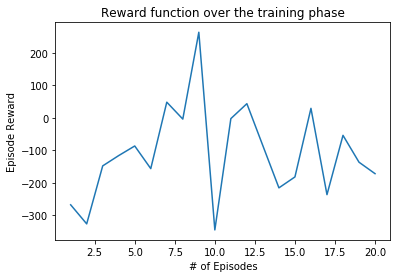

In [8]:
if __name__ == "__main__":
    
    # Number of steps per given episode
    MAX_STEPS = 2000

    # Maximum number of episodes for training
    MAX_EPISODES = 20

    env = gym.make('LunarLander-v2')
    env.seed(0)
    np.random.seed(0)

    # Get Action Size from the Action Space
    ACTION_SIZE = env.action_space.n # 4 discrete action (Do nothing, fire left engine, fire main engine, fire right engine)
    print("Action Space:", ACTION_SIZE)

    # Get State Size from the Observation Space
    STATE_SIZE = env.observation_space.shape[0]
    print("Observation Space:", STATE_SIZE)
    
    training_score_history = train_agent(env, STATE_SIZE, ACTION_SIZE, MAX_STEPS, MAX_EPISODES)
    x_values = range(1,len(training_score_history)+1)

    x_axis = '# of Episodes'
    y_axis = 'Episode Reward'
    plot_title = 'Reward function over the training phase'
    save_figure = True
    plot_save_path = os.path.join(ASSETS_PATH,"training_plot.png")
    
    train_plot = create_plot(x_values, training_score_history, x_axis, y_axis, plot_title, save_figure, plot_save_path)
    
    train_plot.show()
    
    env.close() # close the environment   